# Jacksonville Housing Prices Time Series Analysis


## Luke DiPerna

### January 2023


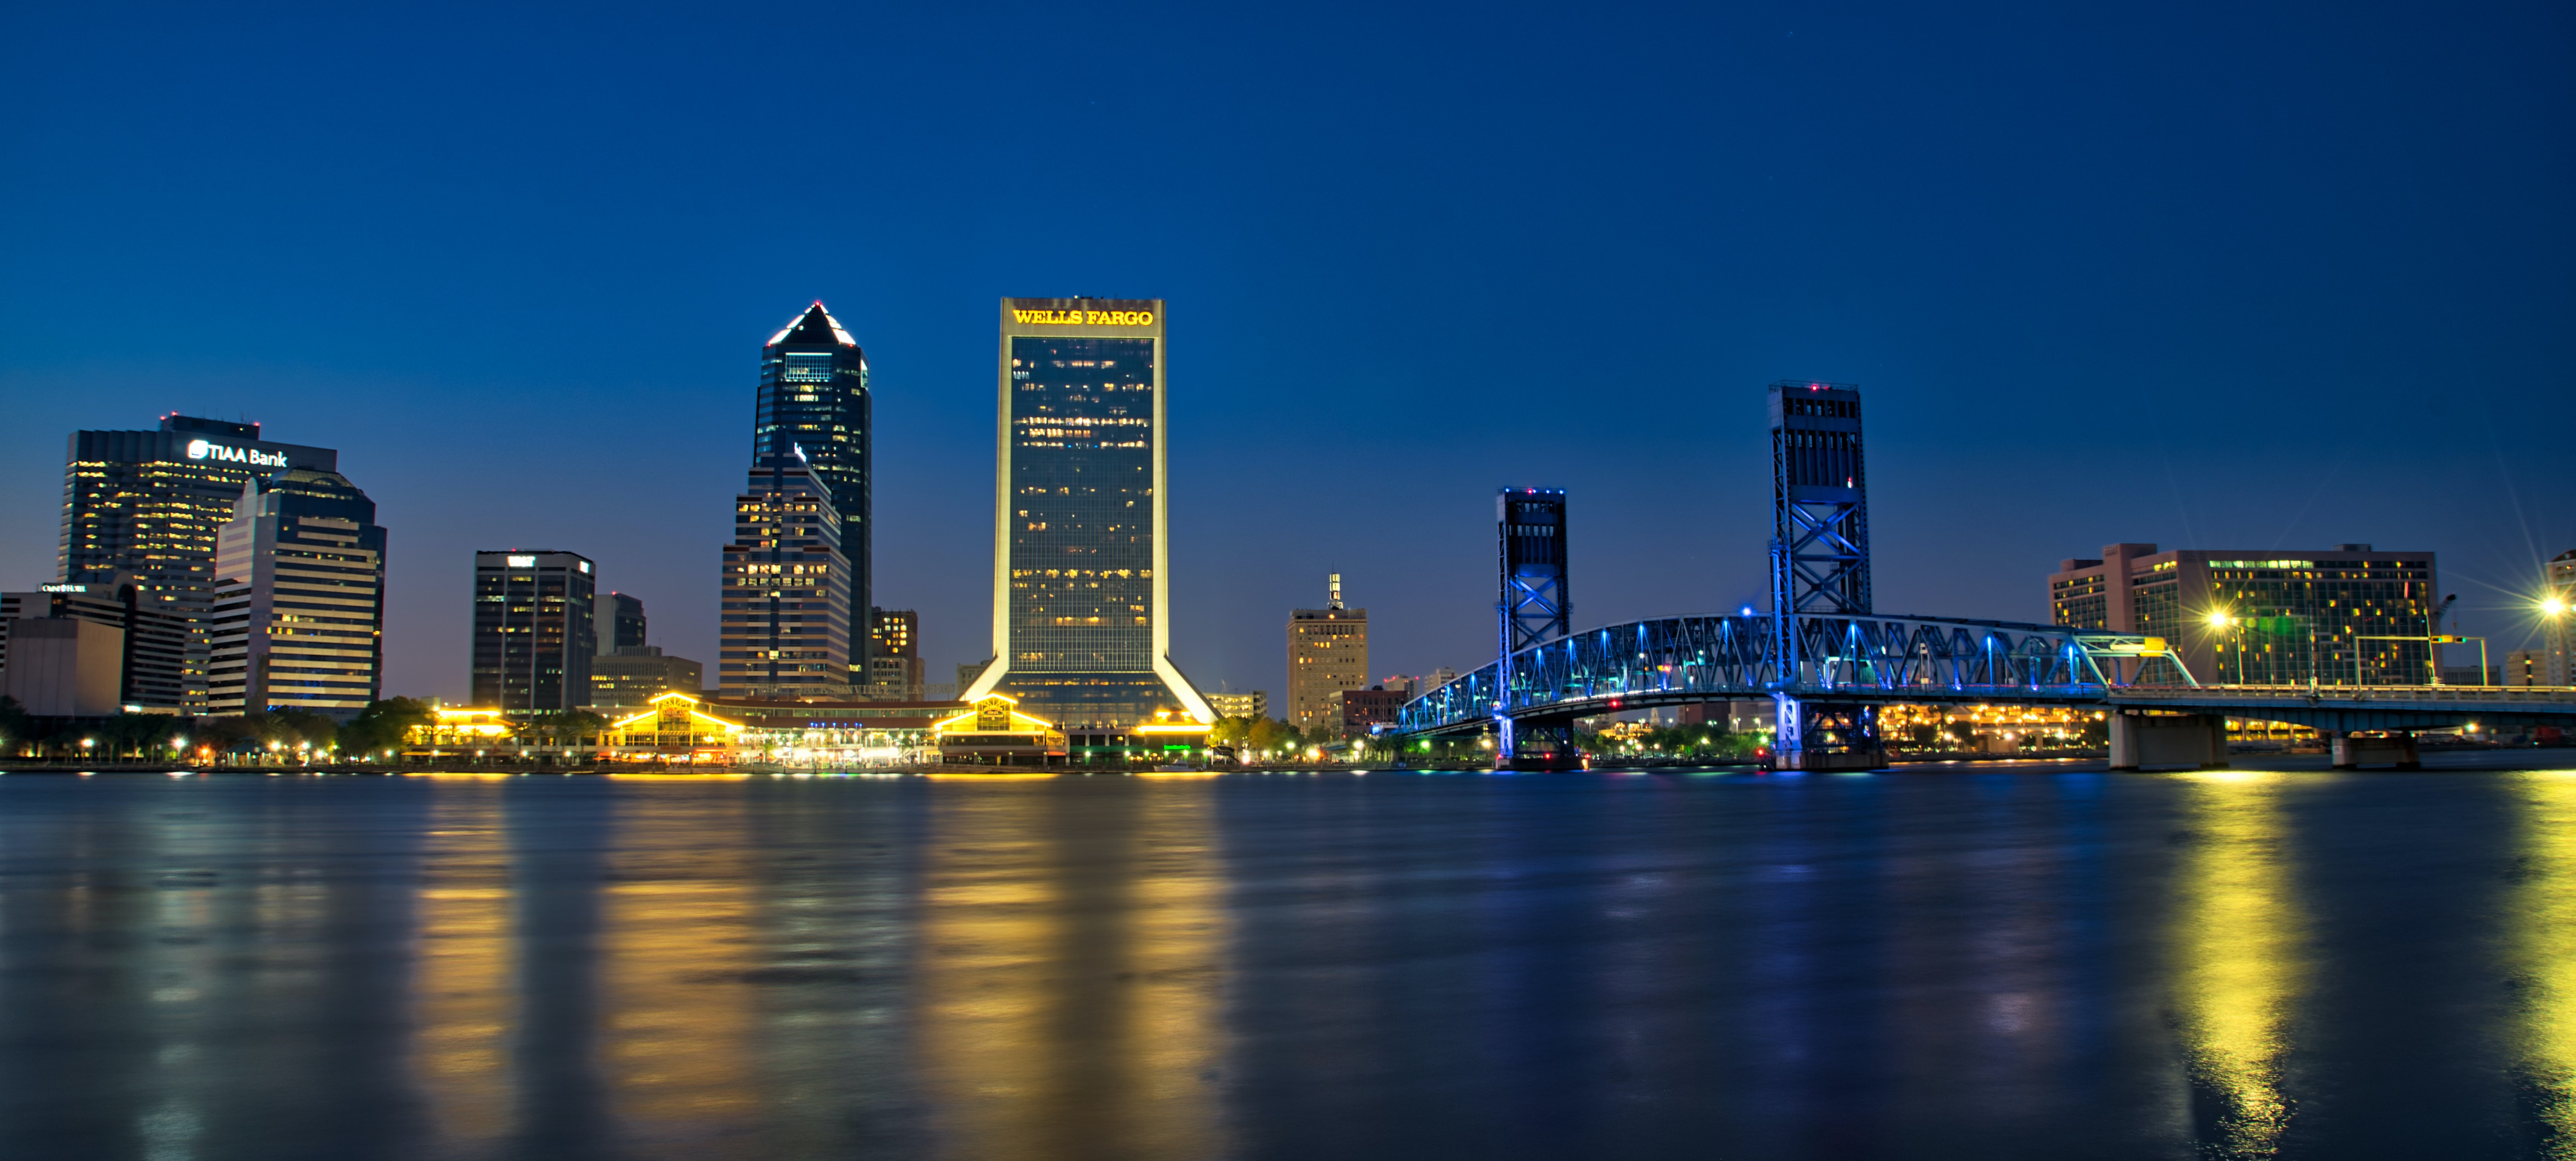

Photo by <a href="https://unsplash.com/pt-br/@encode?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Sean Burgess</a> on <a href="https://unsplash.com/photos/zNrZ12BfSUU?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Project Goal:

The goal of this project is to use time series data from Zillow to forecast home prices in Jacksonville, Fl. I will take the role of an analyst for a real estate consulting agency. The agency specializes in helping clients relocate in a relatively short time frame. The current client I am working with is a contractor who just agreed to a 2-year contract with a company based in Jacksonville, Fl.

The contract starts in 3 months, so the client would like to be in their new home by that time. They have a budget of $275,000. Additionally, there is a chance that they will be relocating again at the end of the current contract, so they would like to buy a home that will offer the best ROI if they need to sell it in 2 years time. My job is to help narrow the search by identifying zip codes in the Jacksonville area that meet the clients criteria. Once this is done, the client can make an informed choice while considering other options (commute time, neighborhood, convenience, etc.).

## Table of Contents

- [Understanding the Data](#Understanding-the-Data)
- [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis(EDA))

- [Time Series Analysis](#Time-Series-Analysis)
    - [Naive Model](#Naive-Model)
    - [Model Building](#Model-Building)
    
    
    - [K-Nearest Neighbors(KNN)](#K-Nearest-Neighbors(KNN))
    - [Random Forests (RF)](#Random-Forests-(RF))
- [Model Evaluation](#Model-Evaluation)
- [Bias and Fairness Metrics](#Bias-and-Fairness-Metrics)
- [Conclusion](#Conclusion)

## Understanding the Data

The main dataset is a collection of median housing prices from [Zillow](https://www.zillow.com/research/data/) dating back to 1996 and grouped by zip code. I will perform EDA and preprocess the data so that it is ready for time series analysis.

The data has been smoothed and the seasonality has been removed. This means the analysis will be simpler, but also means some information is lost. In the Appendix, I will use additional seasonal data from Zillow to demonstrate how a more nuanced analysis could be performed. Unfortunately, the seasonal data is only available by city instead of zip code, but it still offers some insight when forecasting future house prices.

## Exploratory Data Analysis

EDA will consist of visualizing the data and processing it so that time series analysis can be performed.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import itertools
import json
import folium

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# ! pip install pmdarima
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# set global style
sns.set_theme()
rcParams['figure.figsize'] = 15, 8
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
# plt.rcParams['axes.xmargin'] = 0

In [19]:
# import Zillow dataset
df = pd.read_csv('data/zillow_monthly_zc_data.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,111025.364504,...,262174.177552,267031.277605,271167.441993,274949.991267,277857.050380,279379.374979,279571.703469,278978.533186,278001.127045,276453.815200
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,217709.460879,...,452790.345320,460467.367267,467482.802830,473572.893250,477267.065068,477984.861877,476524.002739,474871.543073,473490.978602,471547.993017
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,93297.846024,...,177893.551274,180425.647045,182618.423967,184808.073687,186768.821493,188315.027071,189360.332747,190107.287314,190872.067470,191400.577159
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,75454.474440,...,336045.570757,336639.762806,336736.022093,337304.550369,337577.574287,336818.929821,335031.093053,333107.358734,332435.128586,331124.345954
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,237548.770794,...,740994.162841,743614.071840,750129.456105,757964.299916,763316.251684,764586.578334,761489.401151,758818.529559,756929.158762,753410.376751


The zip codes are located in the `RegionName` column. I will limit the data to only include entries from the Jacksonville Metropolitan Region, which contains all the zip codes in the greater Jacksonville area. The data is also in a wide format, so I will need to put it in long format before conducting any time series analysis.

In [70]:
jax_df = df[df['Metro'] == 'Jacksonville, FL']
jax_df.head()

KeyError: 'Metro'

In [21]:
id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'City', 'Metro', 'CountyName']

def aggregate_city_data(df):
    '''
    Aggregate all the data for the Jacksonville area
    and convert it from wide to long format.
    '''
    melted = pd.melt(df,
                     id_vars=id_vars,
                     var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    
    return melted.groupby('time').aggregate({'value':'mean'})

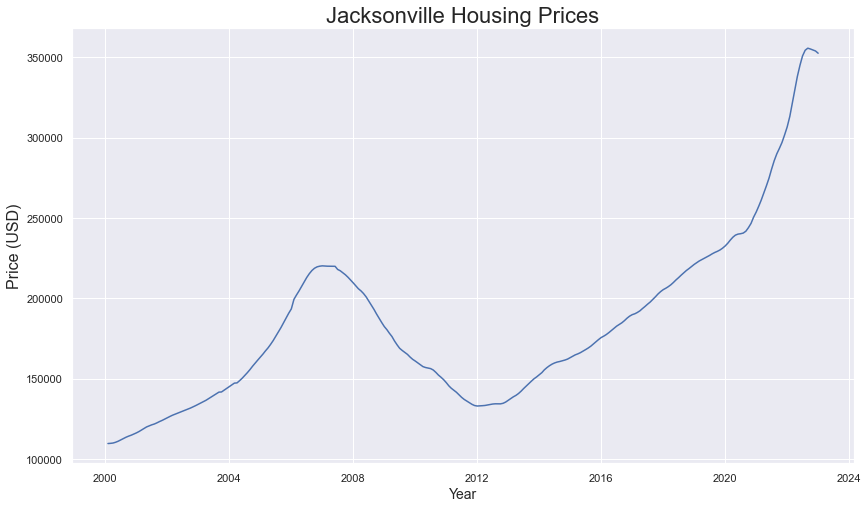

In [67]:
# create Jacksonville time series
jax_ts = aggregate_city_data(jax_df)

# plot Jacksonville data
fig,ax = plt.subplots()

ax.plot(jax_ts)
ax.set_title('Jacksonville Housing Prices')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year');

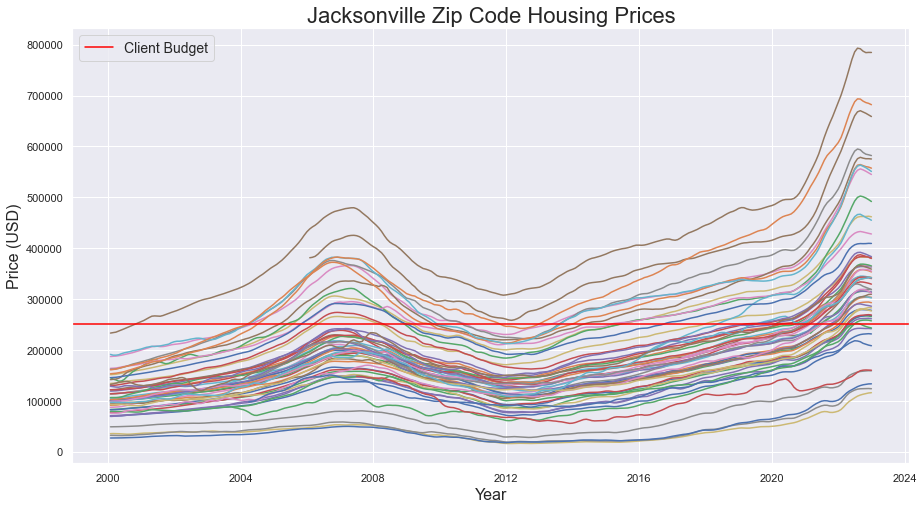

In [73]:
# create lists to hold zip codes and corresponding time series
loc_list = []
ts_list = []

# create seperate time series for each zip code in Jacksonville
for region in jax_df['RegionName'].unique():
    
    init_df = jax_df[jax_df['RegionName'] == region]
    
    # wide to long format
    melted_df = pd.melt(init_df, id_vars=id_vars, var_name='time', value_name='price')
    melted_df['time'] = pd.to_datetime(melted_df['time'], infer_datetime_format=True)
    
    df = melted_df.drop(id_vars, axis=1)
    df.set_index('time', inplace=True)
    
    # add zip code and time series to lists
    loc_list.append(region)
    ts_list.append(df)  

fig,ax = plt.subplots()
# plot price data for each zip code
for zip_code in ts_list:
    ax.plot(zip_code)

# plot client budget
ax.axhline(y=250000, c='red', label='Client Budget')

ax.set_title('Jacksonville Zip Code Housing Prices')
ax.set_ylabel('Price (USD)')
ax.set_xlabel('Year')
ax.legend(loc=2, fontsize=14);

We can see a fairly consistent pattern acros each zip code, though some seem to be growing faster than others. Since the clients budget is 275,000, I will limit the zip codes to those with a current median price between 200,000 and 300,000.

In [24]:
budget_ts = []
budget_loc = []

# keep zip codes that are within budget range
for idx in range(len(ts_list)):
    if 200000 <= float(ts_list[idx].iloc[-1]) <= 300000:
        budget_ts.append(ts_list[idx])
        budget_loc.append(loc_list[idx])
        
for ts in budget_ts:
    ts.dropna(inplace=True)

In [76]:
# current median price in each zip code
current_prices = [float(ts.iloc[-1]) for ts in budget_ts]
current_prices_sorted = sorted(zip(current_prices, budget_loc))
current_prices_sorted

[(208151.0629042606, 32087),
 (231340.2126068994, 32210),
 (241594.57740766823, 32211),
 (243086.1759607381, 32145),
 (257090.0376046557, 32656),
 (261167.54079645488, 32205),
 (265413.87049580755, 32244),
 (267611.933646926, 32216),
 (268455.21375983354, 32207),
 (276510.4214166018, 32666),
 (277733.4062595222, 32277),
 (282548.35287346854, 32219),
 (285851.6218673427, 32063),
 (292784.5902438749, 32220)]

In [77]:
# corresponding zip codes and current median prices
zip_codes = [zip_code for _, zip_code in current_prices_sorted]
prices = [price for price, _ in current_prices_sorted]

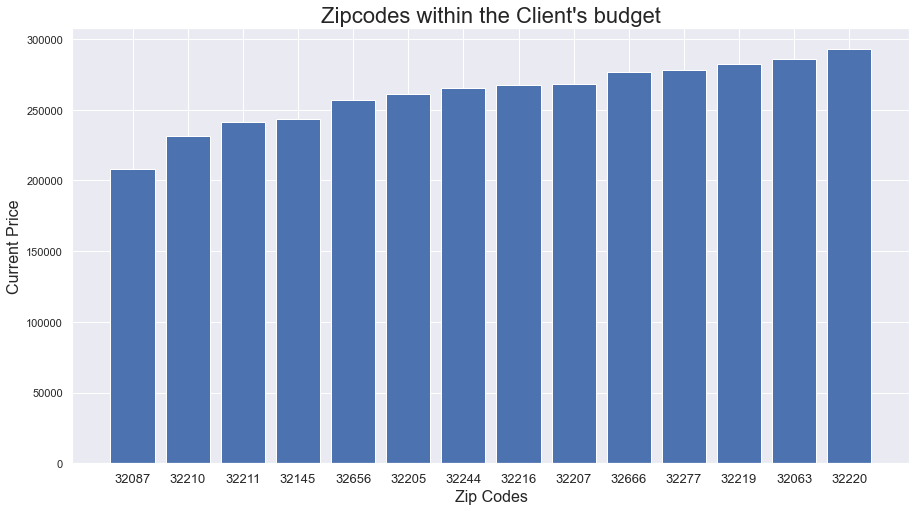

In [82]:
fig,ax = plt.subplots()
# plot current median prices
ax.bar(x=range(len(prices)), height=prices)
ax.set_xticks(range(len(prices)))
ax.set_xticklabels(zip_codes, fontsize=13)
ax.set_title("Zipcodes within the Client's budget")
ax.set_ylabel("Current Price")
ax.set_xlabel("Zip Codes");

In [29]:
# calculate 3 and 6 year roi
roi_3_yr = [float((ts.loc['2022-12-31'] - ts.loc['2020-01-31']) / ts.loc['2020-01-31']) for ts in budget_ts]
roi_6_yr = [float((ts.loc['2022-12-31'] - ts.loc['2017-01-31']) / ts.loc['2017-01-31']) for ts in budget_ts]

[0.5254785509388434,
 0.5026093912605618,
 0.4912508974808869,
 0.47796974603377185,
 0.5007313741934231,
 0.4104938237702976,
 0.4918983627457858,
 0.5883191118596822,
 0.5186192508716619,
 0.5289223041328607,
 0.4458173897374306,
 0.5044105562509357,
 0.2853203605410861,
 0.5026303317958581]

In [30]:
zips_6 = [zip_code for _, _, zip_code in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]
roi_6 = [roi for roi, _, _ in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]
roi_3 = [roi for _, roi, _ in sorted(zip(roi_6_yr, roi_3_yr, budget_loc))]

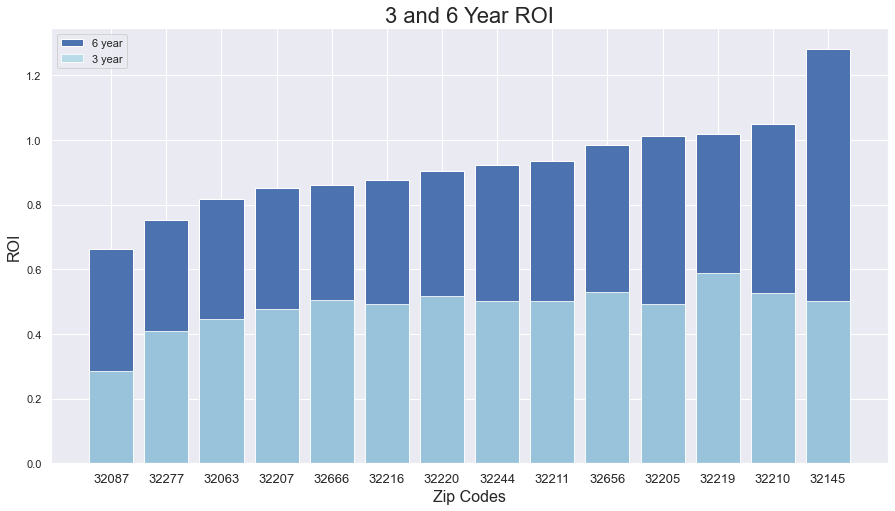

In [86]:
fig,ax = plt.subplots()

# plot 6 year roi
ax.bar(x=range(len(roi_6)), height=roi_6, label='6 year')
#plot 3 year roi
plt.bar(x=range(len(roi_3)), height=roi_3, label='3 year', color='lightblue', alpha=.8)

ax.set_xticks(range(len(roi_6)))
ax.set_xticklabels(zips_6, fontsize=13)
ax.set_title("3 and 6 Year ROI",)
ax.set_ylabel("ROI")
ax.set_xlabel("Zip Codes");
ax.legend();

## Time Series Analysis

Now that I have examined historic housing prices, I will turn to creating a time series model. To do so, I will use the Dickey-Fuller test as a metric for determining the stationarity of the data, which is needed if I am to perform time series analysis. I will then need to determine the optimal order of the auto-regression(AR) and moving average(MA).

I will build an initial model using the Jacksonville average time series data, then repeat the process for each zip code. I can then forecast the price in 2 years and calculate the ROI for each zip code.

### Naive Model

The baseline model will be a "naive" model, which shifts all the data points by one position, as demonstrated below. I will use it to calculate a RMSE score that can be compared to other moments.

RMSE = 2038.1048299075253


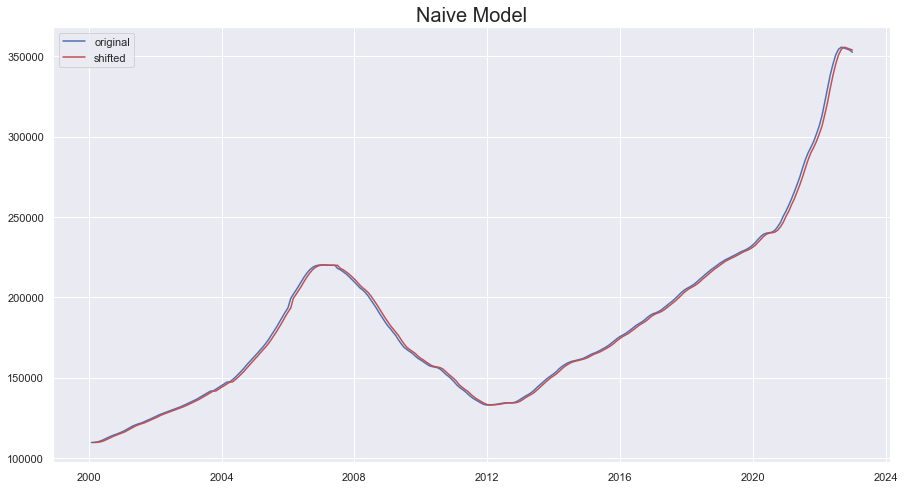

In [58]:
# create naive model
naive_jax = jax_ts.shift(1)

fig, ax = plt.subplots()
# plot data and naive model
ax.plot(jax_ts, c='b', label='original')
ax.plot(naive_jax, c='r', label='shifted')
ax.set_title('Naive Model')
ax.legend();

print(f'RMSE = {np.sqrt(mean_squared_error(jax_ts[1:], naive_jax.dropna()))}')

### Model Building

I will demonstrate the need for differencing the data before model, as well as the method by which I will determine the parameters for the model.

The function below will allow my to quickly evaluate the results of the Dickey-Fuller test.

In [33]:
def dickey_fuller(ts, prnt=True):
    '''
    Create a dataframe with the results of the Dickey-Fuller Test.
    ---
    Input:
    
    ts: time series to be evaluated
    prnt: print results if True, else returns the p-value
    '''
    # perform dickey-fuller test
    dickey = adfuller(ts)
    
    if prnt:
        results = pd.Series(dickey[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
        for key,value in dickey[4].items():
            results['Critical Value (%s)'%key] = value
            
        print('Results of Dickey-Fuller Test: \n')
        print(results)
        
    else:
        # p-value
        return dickey[1]

In [87]:
# test stationarity of the time series
dickey_fuller(jax_ts)

Results of Dickey-Fuller Test: 

Test Statistic                  -0.817756
p-value                          0.813851
#Lags Used                       3.000000
Number of Observations Used    272.000000
Critical Value (1%)             -3.454622
Critical Value (5%)             -2.872225
Critical Value (10%)            -2.572464
dtype: float64


A p-value of 0.81 suggests that the data is non-stationary. Since the seasonality has already been smoothed, I can focus on de-trending the data. One way is to perform differencing, which creates a new time series that is takes the difference between each data point and the previous data point.

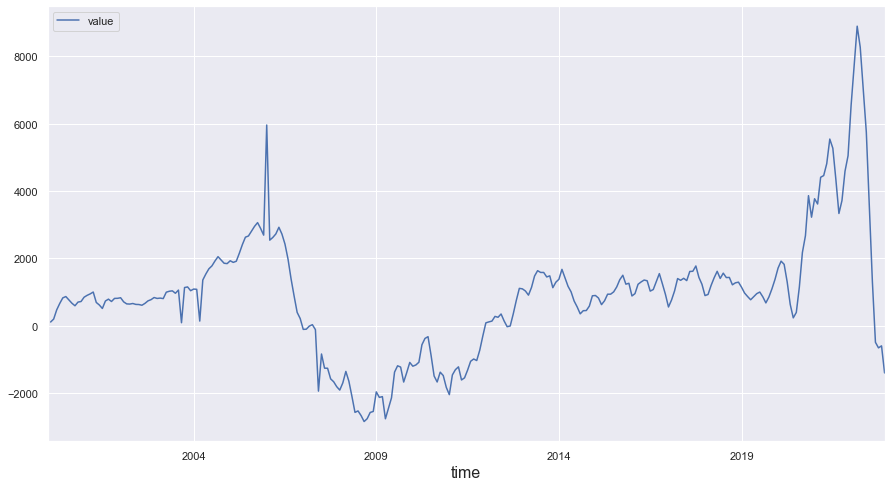

In [88]:
# difference and plot the resulting data
jax_diff = jax_ts.diff()
jax_diff.plot();

In [36]:
dickey_fuller(jax_diff.dropna())

Results of Dickey-Fuller Test: 

Test Statistic                  -3.888617
p-value                          0.002120
#Lags Used                      16.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64


The drop in p-value from 0.813 to 0.002 suggests that the data has been successfully de-trended. This does not mean that I am done, as I still need to see what degree of AR and MA might further improve the model, but it does mean that I will need to difference the data.

#### Train-Test Split

In order to test the model, I will create a train-test split of 80-20. The choice of split is espceially important with the current data because of the change in behavior starting from around 2021. After this point in time, the housing prices begin to increase at a much faster rate before flattening out in the last few months. 

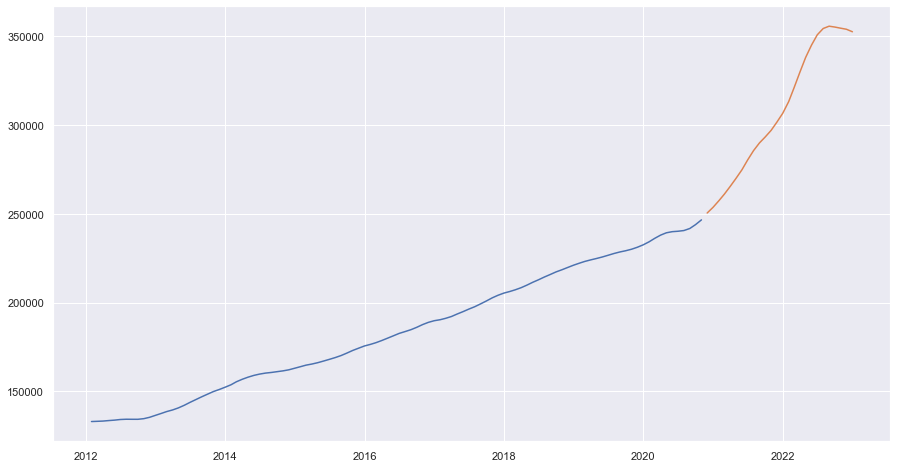

In [37]:
X = jax_ts['2012-01-31':]
X_diff = jax_diff['2012-01-31':].dropna()

cutoff = round(X.shape[0]*0.8)
cutoff_diff = round(X_diff.shape[0]*0.8)

train = X[:cutoff]
test = X[cutoff:]

train_diff = X_diff[:cutoff_diff]
test_diff = X_diff[cutoff_diff:]

plt.plot(train)
plt.plot(test);

In [38]:
model = auto_arima(train,       # whole or train
                   start_p=0,
                   start_q=0,
                   test='adf',
                   max_p=5,
                   max_q=5,
                   m=1,
                   d=None,
                   seasonal=False,
                   trace=True,
                   stepwise=True,
                   with_intercept=False
                  )

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1447.524, Time=0.40 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1446.984, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1446.937, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=1448.929, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=1448.916, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=1446.982, Time=0.21 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=1447.661, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.293 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  106
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -721.469
Date:                Wed, 22 Mar 2023   AIC                           1446.937
Time:                        20:06:00   BIC                           1452.226
Sample:                

In [39]:
# ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train, 
#                                         order=(0,2,1), 
#                                         seasonal_order=(0,0,0,0), 
#                                         enforce_stationarity=False, 
#                                         enforce_invertibility=False)
# output = ARIMA_MODEL.fit()

In [40]:
ARIMA_MODEL = ARIMA(train,#train 
                                        order=(0,2,1),
                                        seasonal_order=(0,0,0,0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
output = ARIMA_MODEL.fit()

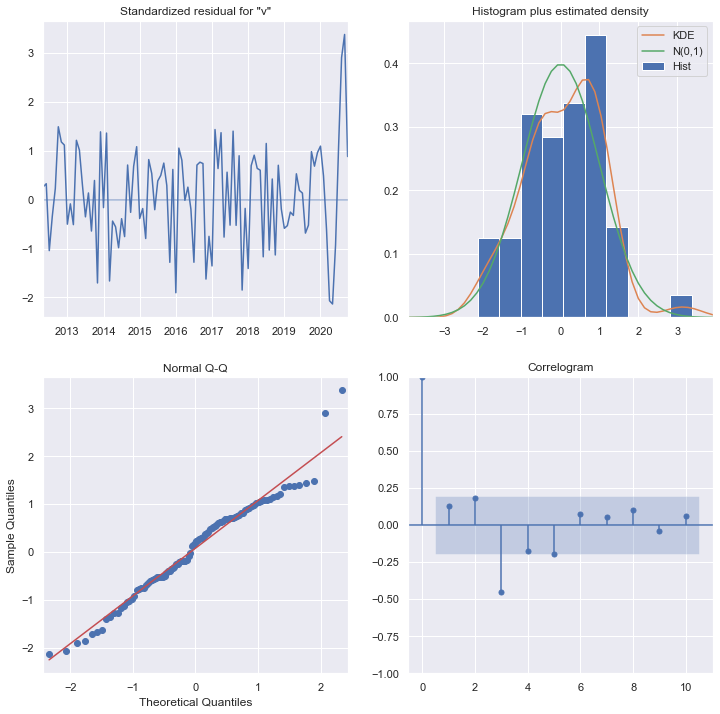

In [41]:
output.plot_diagnostics(figsize=(12, 12));

In [42]:
# model = auto_arima(train_diff,
#                    start_p=0,
#                    start_q=0,
#                    test='adf',
#                    max_p=3,
#                    max_q=3,
#                    m=1,
#                    d=None,
#                    seasonal=False,
#                    trace=True,
#                    stepwise=True,
#                    with_intercept=False)

# print(model.summary())

In [43]:
# ARIMA_MODEL = sm.tsa.statespace.SARIMAX(train_diff, 
#                                         order=(3,1,0), 
#                                         seasonal_order=(0,0,0,0), 
#                                         enforce_stationarity=False, 
#                                         enforce_invertibility=False)
# output = ARIMA_MODEL.fit()

In [44]:
# output.plot_diagnostics(figsize=(12, 12));

In [45]:
pred = output.get_prediction(start=pd.to_datetime('2020-10-31'), end=pd.to_datetime('2022-12-31'), dynamic=False)
pred_conf = pred.conf_int()

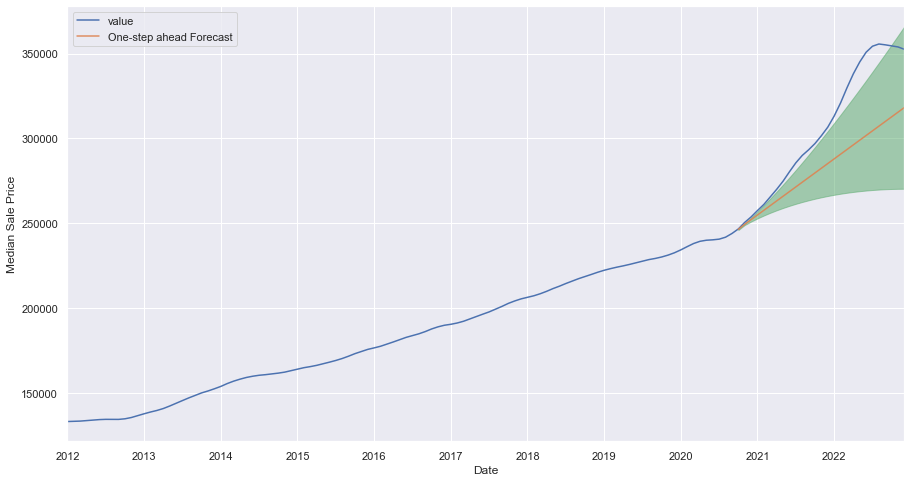

In [46]:
rcParams['figure.figsize'] = 15, 8

# Plot observed values
ax = X.plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index.values,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')
plt.legend()

plt.show()

## As expected, it can't account for the covid boom with basically 0 interest rates. should stabilize though (See Appendix)

In [47]:
ARIMA_MODEL = ARIMA(X, 
                    order=(0,2,1), 
                    seasonal_order=(0,0,0,0), 
                    enforce_stationarity=False, 
                    enforce_invertibility=False)
output = ARIMA_MODEL.fit()

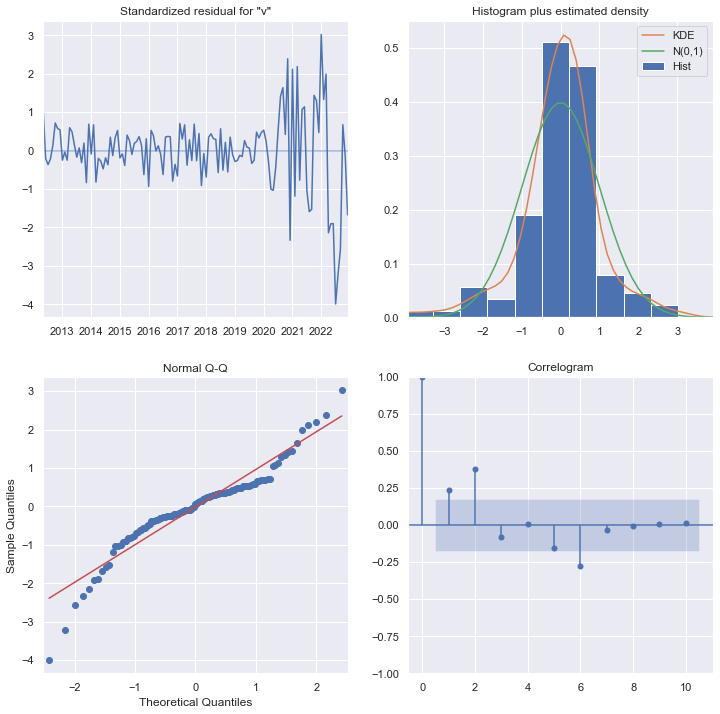

In [48]:
output.plot_diagnostics(figsize=(12, 12));

In [49]:
# Get forecast 500 steps ahead in future
forecast = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
forecast_conf = forecast.conf_int()

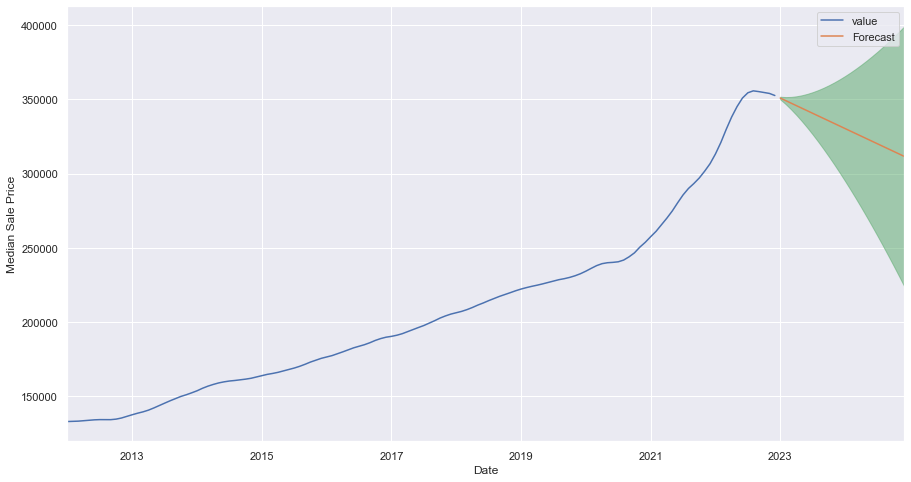

In [50]:
ax = X.plot(label='observed', figsize=(15, 8))

forecast.predicted_mean.plot(ax=ax, label='Forecast')

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index.values,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Sale Price')

plt.legend()
plt.show()

## Now we will repeat process for each zip code in Jacksonville.

In [51]:
forecast_rois = {}
fc_rois = []

for idx in range(len(budget_ts)):
    
    X = budget_ts[idx]['2012-01-31':]
    cutoff = round(X.shape[0]*0.8)

    train = X[:cutoff]
    test = X[cutoff:]

    model = auto_arima(train,       #train
                       start_p=0,
                       start_q=0,
                       test='adf',
                       max_p=5,
                       max_q=5,
                       m=1,
                       d=2,
                       seasonal=False,
                       trace=False,
                       stepwise=True,
                       with_intercept=False)
    
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(X,
#                                             order=(0,2,1),
                                            order= model.order, 
                                            seasonal_order= model.seasonal_order, 
                                            enforce_stationarity=False, 
                                            enforce_invertibility=False)
    
    output = ARIMA_MODEL.fit()
    
    forecast = output.get_forecast(24)
    forecast_conf = forecast.conf_int()
    forecast_conf['pred'] = forecast.predicted_mean
    
    forecast_rois[budget_loc[idx]] = ((forecast_conf['pred'][-1]) - (X['price'][-1])) / (X['price'][-1])
    fc_rois.append(((forecast_conf['pred'][-1]) - (X['price'][-1])) / (X['price'][-1]))
print(forecast_rois)
print(fc_rois)
#     forecasts[budget_loc[idx]] = 

#     ax = X.plot(label='observed', figsize=(15, 8))

#     forecast.predicted_mean.plot(ax=ax, label='Forecast')

#     # Plot the range for confidence intervals
#     ax.fill_between(forecast_conf.index.values,
#                     forecast_conf.iloc[:, 0],
#                     forecast_conf.iloc[:, 1], color='g', alpha=0.5)

#     ax.set_xlabel('Date')
#     ax.set_ylabel('Median Sale Price')

#     plt.legend()
#     plt.show()

# print(model.summary())

{32210: -0.04897134849896961, 32244: -0.12968930755812066, 32216: -0.10092787661557899, 32207: -0.06863872641871949, 32211: -0.14484733278135947, 32277: -0.08013799359397193, 32205: -0.09018378405530035, 32219: -0.1869710367970753, 32220: -0.2871772487372276, 32656: -0.11780188677357765, 32063: -0.13799952911089647, 32666: -0.13079447441729453, 32087: -0.1359670061617075, 32145: -0.12910364374076827}
[-0.04897134849896961, -0.12968930755812066, -0.10092787661557899, -0.06863872641871949, -0.14484733278135947, -0.08013799359397193, -0.09018378405530035, -0.1869710367970753, -0.2871772487372276, -0.11780188677357765, -0.13799952911089647, -0.13079447441729453, -0.1359670061617075, -0.12910364374076827]


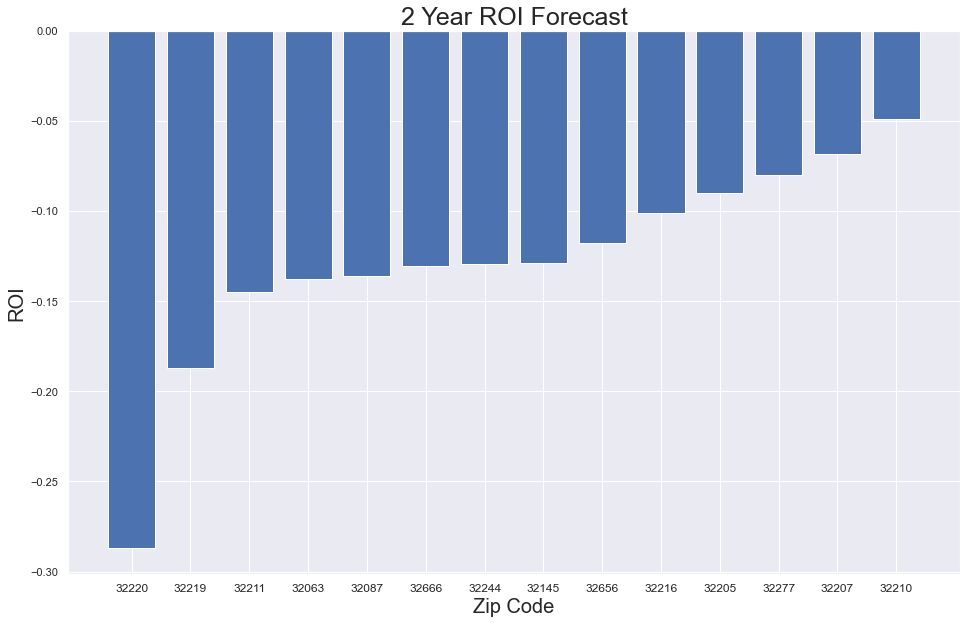

In [52]:
roi_zips = [zip_code for _, zip_code in sorted(zip(fc_rois, budget_loc))]
roi_totals = [roi for roi, _ in sorted(zip(fc_rois, budget_loc))]

fig,ax = plt.subplots(figsize=(16,10))

ax.bar(x=range(len(roi_totals)), height=roi_totals, label='roi')
ax.set_xticks(range(len(roi_zips)))
ax.set_xticklabels(roi_zips,fontsize='12')
ax.set_title("2 Year ROI Forecast",fontsize='25')
ax.set_ylabel("ROI",fontsize='20')
ax.set_xlabel("Zip Code",fontsize='20');

# ax.legend();

In [53]:
top_5_zips = roi_zips[-5:]
top_5_roi = roi_totals[-5:]

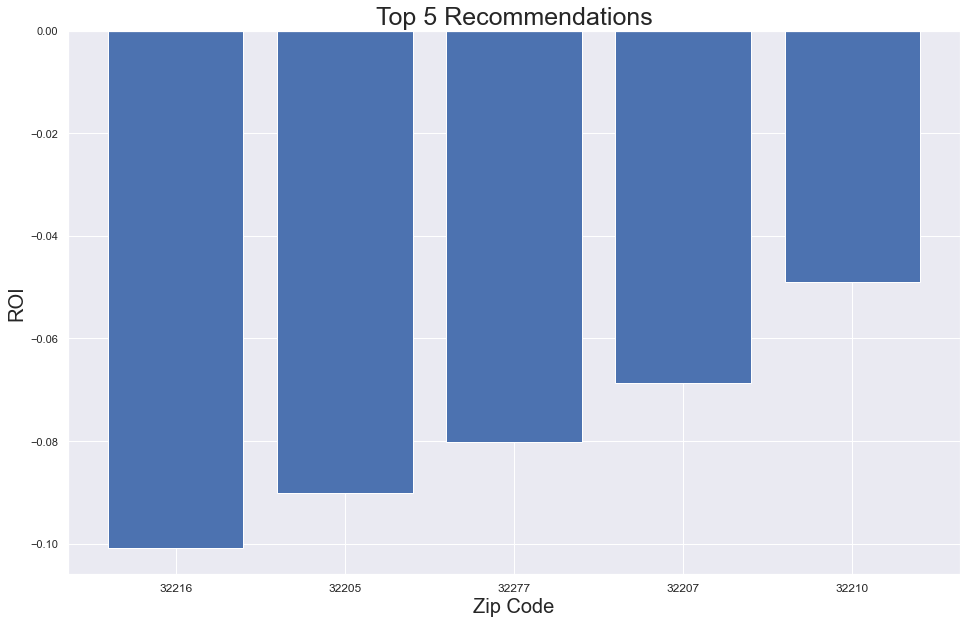

In [54]:
fig,ax = plt.subplots(figsize=(16,10))

ax.bar(x=range(len(top_5_roi)), height=top_5_roi, label='roi')
ax.set_xticks(range(len(top_5_zips)))
ax.set_xticklabels(top_5_zips,fontsize='12')
ax.set_title("Top 5 Recommendations",fontsize='25')
ax.set_ylabel("ROI",fontsize='20')
ax.set_xlabel("Zip Code",fontsize='20');

## These are the recommendations. Though the prediction is that house prices will drop, it is worth noting that there are other factors that would lead to a recovery. For this, see appendix.

Here is a map of the Jacksonville area that highlights my recommended zip codes. In order to create the Folium layers and markers, I needed to use geojson data for florida, which I found [here](https://github.com/OpenDataDE/State-zip-code-GeoJSON).

In [55]:
# load Florida zip code geojson data
f = open('data/fl_florida_zip_codes_geo.min.json')
data = json.load(f)

# new dictionary for jacksonville zip code data
jax_dict = {'features':[]}

# include data from each recommended zip code
for dictionary in data['features'][:]:
    # 'ZCTA5CE10' contains the zip code
    if int(dictionary['properties']['ZCTA5CE10']) in top_5_zips:
        jax_dict['features'].append(dictionary)


In [56]:
# create Jacksonville map
m = folium.Map(location=[30.3322, -81.6557])

# add geojson layer to highlight each zip code
folium.GeoJson(data=(jax_dict), name='layerName').add_to(m)

colors=['red', 'blue', 'green', 'purple', 'orange']

for idx in range(len(jax_dict['features'])):
    
    # central lat,long and name of each zip code
    lat = jax_dict['features'][idx]['properties']['INTPTLAT10']
    long = jax_dict['features'][idx]['properties']['INTPTLON10']
    zc = jax_dict['features'][idx]['properties']['ZCTA5CE10']
    
    #add marker at the center of each zip code
    folium.Marker(location=[lat, long],
                  popup=zc,
                  tooltip=zc,
                  icon=folium.Icon(color=colors[idx], icon='glyphicon-map-marker')
                 ).add_to(m)

m

## APPENDIX

The models built above show a decrease in house prices for all zip codes. The drop in price will likely continue in the near future, but it is almost certain that prices will rebound and continue rising once again. The models, being univariate, have no reliable way to predict when that rebound might occur. In this appendix, I will examine some of the other factors to consider, and how they might be incorporated into a more nuanced analysis if there was more data available.

As noted previously, the data is smoothed, meaning that the seasonal has been removed. While helpful in simplying the analysis, having access to seasonal data can provide more immediate information that can inform forecasts. Unfortunately, the seasonal data is only available at a city level, meaning that there is no zip code data. Therefore, I will use the city data to demonstrate how some of this seasonal information could be used to improve price forecasts, despite not being available at the zip code level.

In [40]:
us_dfs = []
jax_dfs = []

def preprocess_data(df, id_vars, value_name):
    '''
    Prepare and split data for time series analysis.
    
    The raw national data from https://www.zillow.com/research/data/ is in wide format.
    This function then puts the data in long format so time series analysis can be performed.
    Then it creates a new dataframe with only the relevant data (US and JAX), and puts it into a list.
    ---
    Input:
    
    df: a dataframe from csv from https://www.zillow.com/research/data/
    id_vars: all column names except the columns to be melted.
    value_name: name of the new long-format value.
    ---
    Output:
    
    The resulting dataframe.
    '''
    # wide to long format
    data = pd.melt(df, id_vars=id_vars, var_name='time', value_name=value_name)
    
    # only keep US and JAX data
    us_data = data[data['RegionName'] == 'United States']
    jax_data = data[data['RegionName'] == 'Jacksonville, FL']
    
    #set datetime
    us_data['time'] = pd.to_datetime(us_data['time'], infer_datetime_format=True)
    jax_data['time'] = pd.to_datetime(jax_data['time'], infer_datetime_format=True)
    
    # drop everything except time series data
    us_data.drop(id_vars, axis=1, inplace=True)
    us_data.set_index('time', inplace=True)
    
    jax_data.drop(id_vars, axis=1, inplace=True)
    jax_data.set_index('time', inplace=True)
    
    us_dfs.append(us_data)
    jax_dfs.append(jax_data)

In [41]:
# csv files to import 
source_names = ['data/Metro_invt_fs_all home_month.csv',
              'data/Metro_med_doz_pending_all_home_month.csv',
              'data/Metro_median_days_to_close_all_home_month.csv',
              'data/Metro_median_sale_price_all_home_month.csv',
              'data/Metro_median_sale_to_list_all_home_month.csv',
              'data/Metro_new_listings_all_home_month.csv']

value_names = ['forsale_inv',
               'median_days_pending',
               'median_days_to_close',
               'median_sale_price',
               'median_sale_to_list_ratio',
               'new_listings']

id_vars = ['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName']

data_list = [pd.read_csv(file) for file in source_names]

for i in range(len(value_names)):
    preprocess_data(df=data_list[i], id_vars=id_vars, value_name=value_names[i])

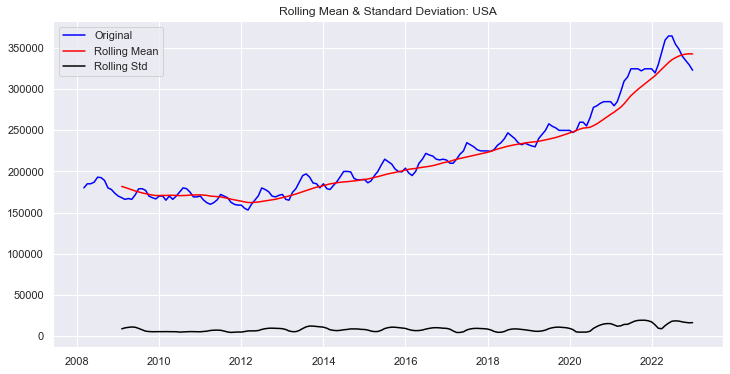

In [42]:
us_median_price = us_dfs[3]

roll_mean = us_median_price.rolling(window=12, center=False).mean()
roll_std = us_median_price.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(us_median_price, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation: USA')
plt.show()

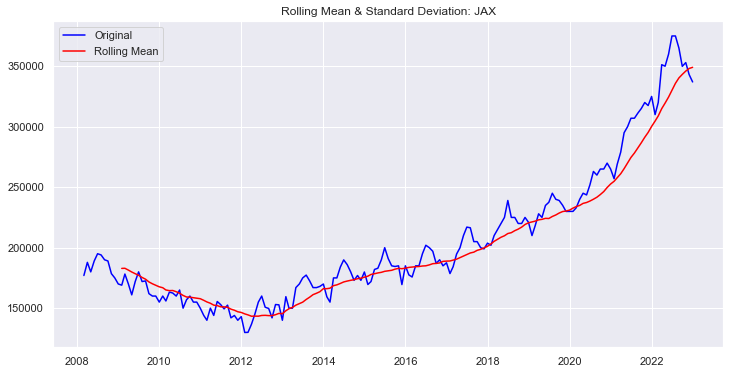

In [43]:
jax_median_price = jax_dfs[3]

roll_mean = jax_median_price.rolling(window=12, center=False).mean()
roll_std = jax_median_price.rolling(window=12, center=False).std()

fig = plt.figure(figsize=(12,6))
plt.plot(jax_median_price, color='blue',label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
# plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation: JAX')
plt.show()